In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('../dataset/train.csv', index_col='id')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [15]:
#change data type to int
df['person_emp_length'] = df['person_emp_length'].astype(int)
df['loan_int_rate'] = np.ceil(df['loan_int_rate'] * 100).astype(int)
df['loan_percent_income'] = np.ceil(df['loan_percent_income'] * 100).astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   person_age                  58645 non-null  int64 
 1   person_income               58645 non-null  int64 
 2   person_home_ownership       58645 non-null  object
 3   person_emp_length           58645 non-null  int64 
 4   loan_intent                 58645 non-null  object
 5   loan_grade                  58645 non-null  object
 6   loan_amnt                   58645 non-null  int64 
 7   loan_int_rate               58645 non-null  int64 
 8   loan_percent_income         58645 non-null  int64 
 9   cb_person_default_on_file   58645 non-null  object
 10  cb_person_cred_hist_length  58645 non-null  int64 
 11  loan_status                 58645 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 5.8+ MB


In [39]:
import seaborn as sns

def draw_hist_plots(df,save_path=None):
    num_cols = df.select_dtypes(include=['int64']).columns
    print(num_cols)
    fig, axes = plt.subplots((len(num_cols) + 2) // 3, 3, figsize=(20, 20))
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], ax=axes[i//3, i%3],kde=True)

    # if save_path is not None:
    #     plt.savefig(save_path)
    

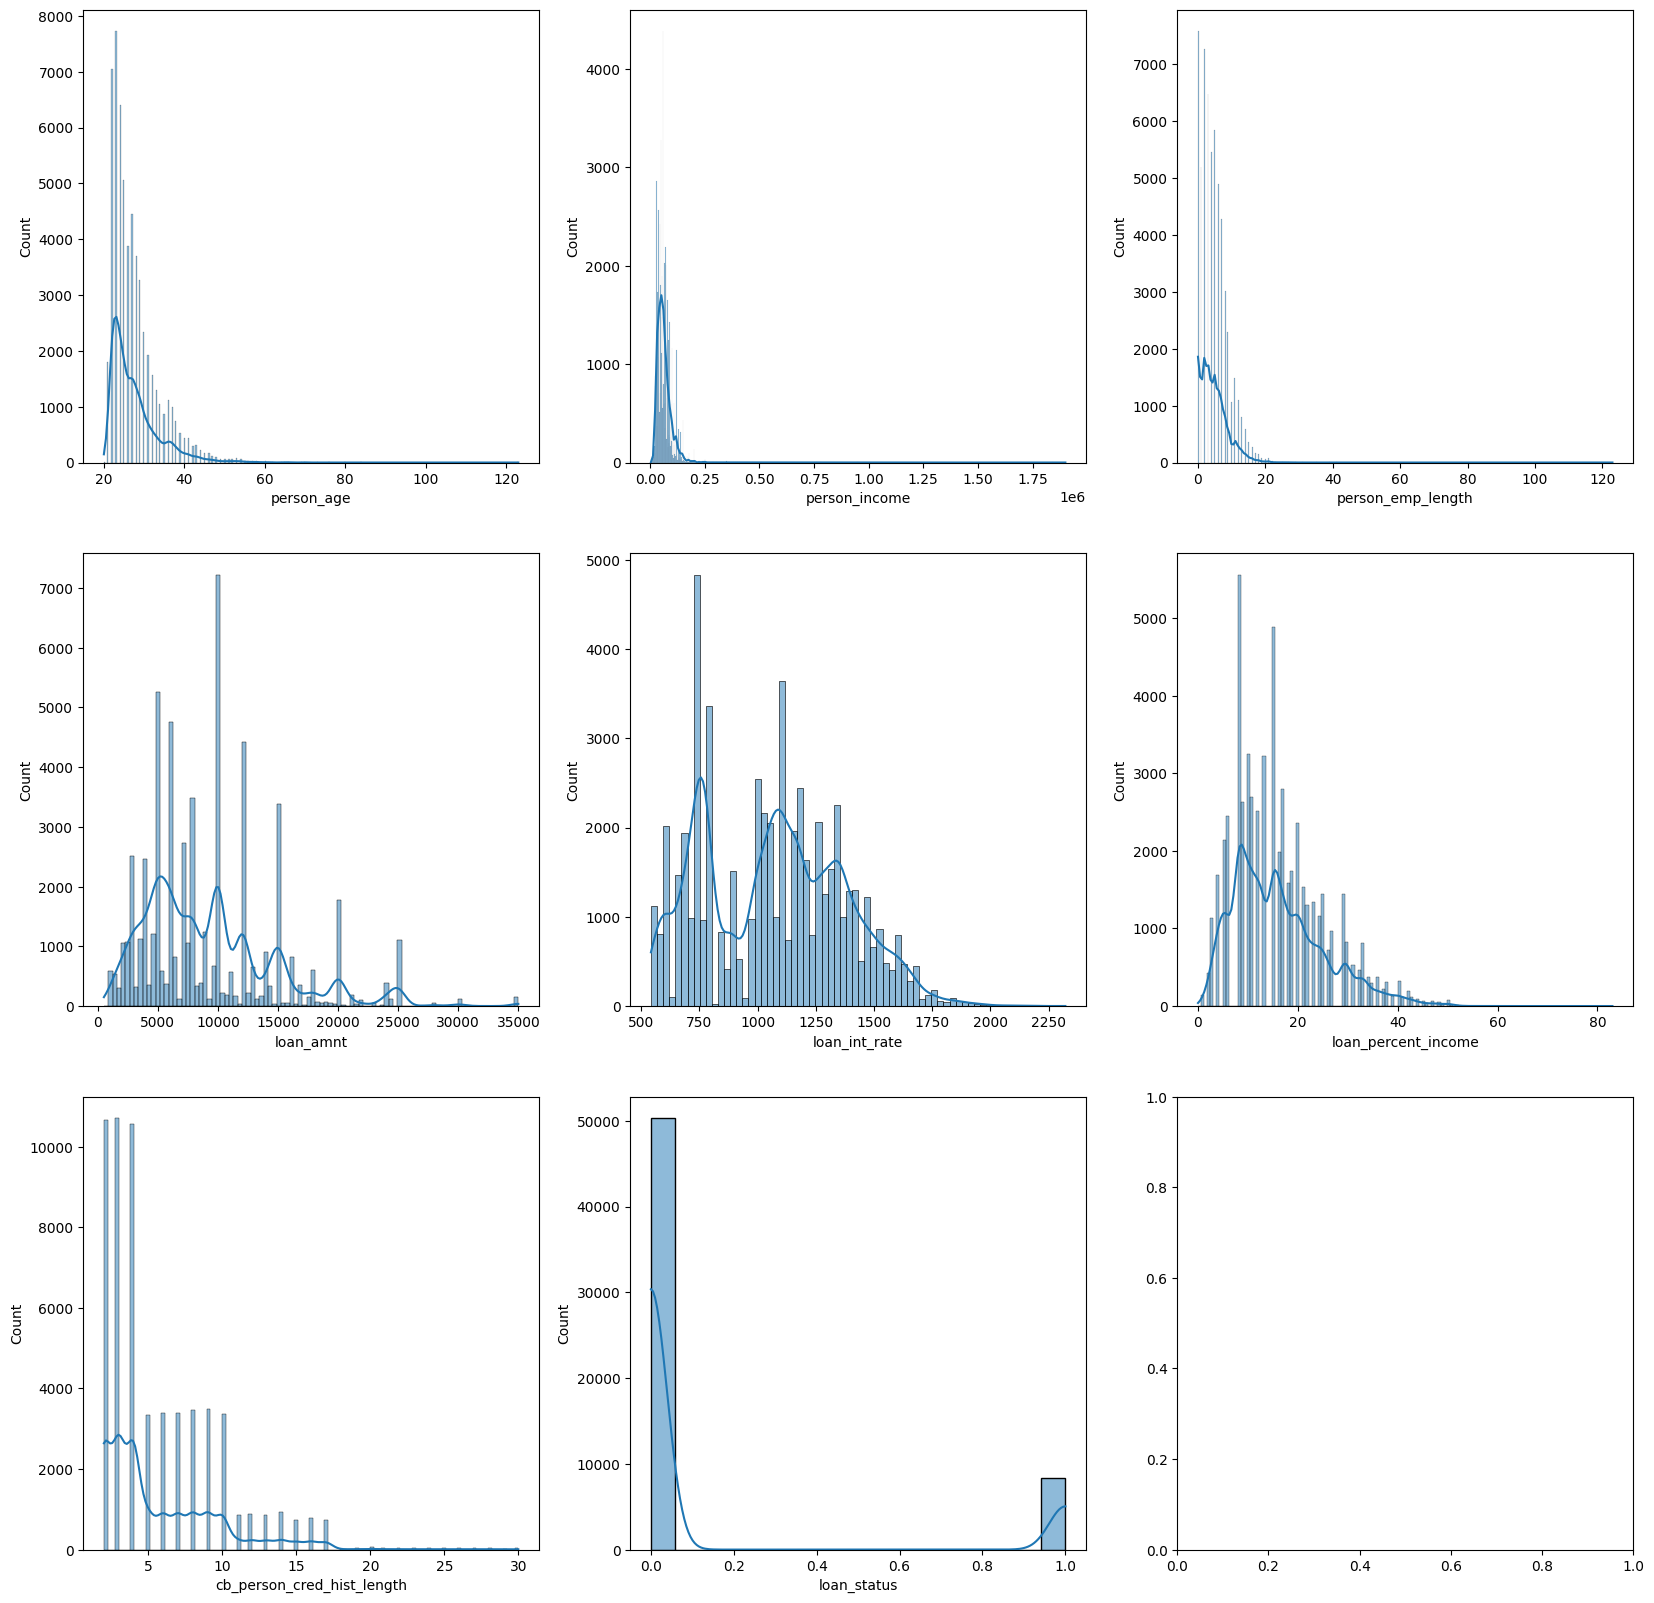

In [18]:
draw_hist_plots(df,save_path='original.png')

In [23]:
# remove outlier using iqr

def remove_outlier(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] > lower_bound) & (df[column] < upper_bound)]
    return df

In [26]:
d = remove_outlier(df, ['person_age','person_income','person_emp_length'])

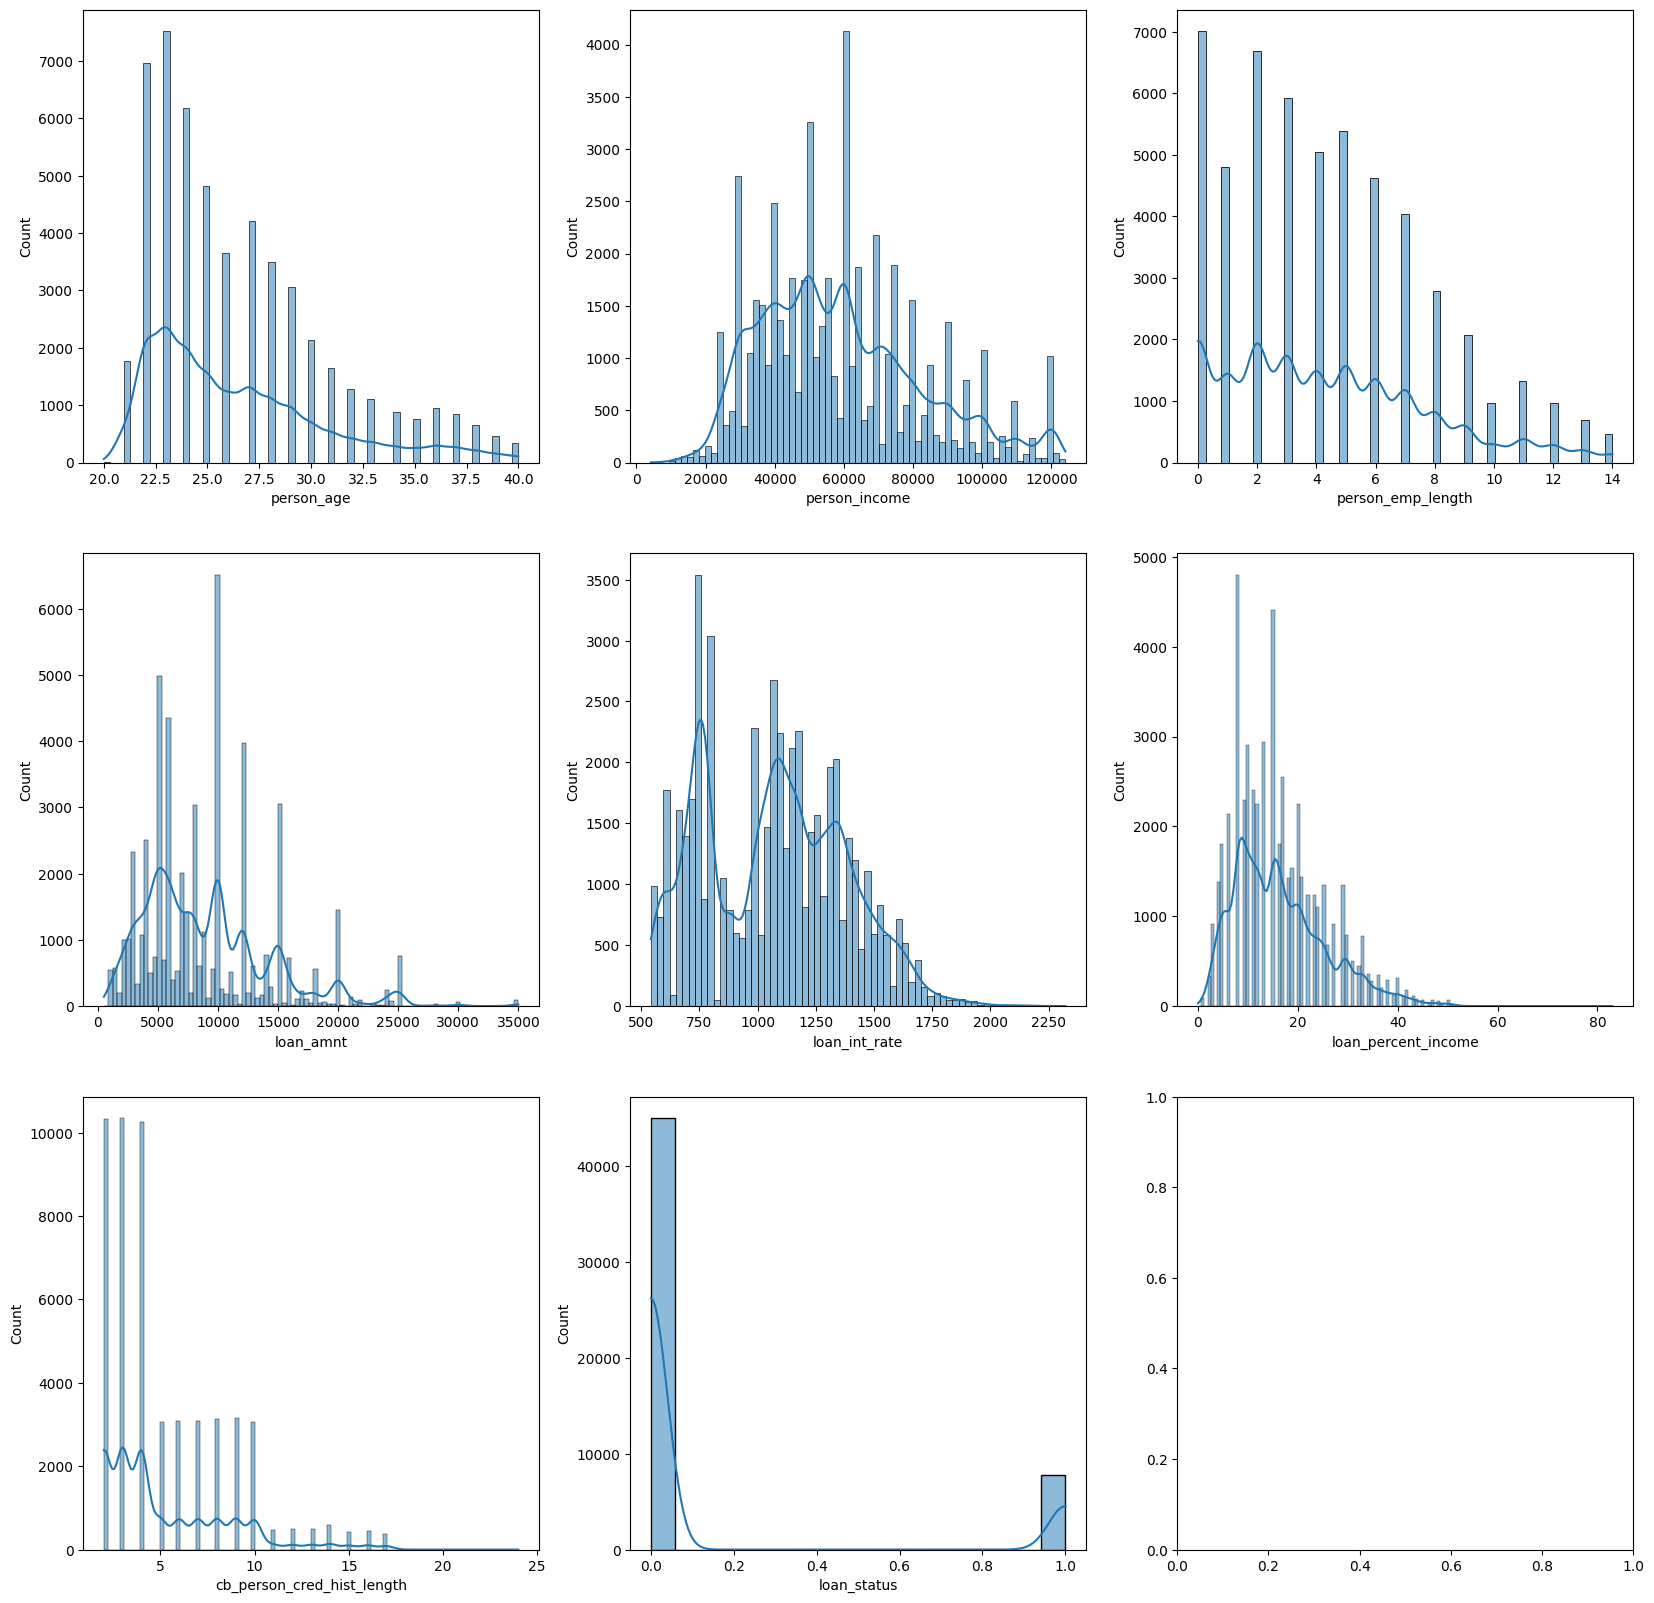

In [27]:
draw_hist_plots(d)

In [42]:
def handle_skewness(df,columns):
    for col in columns:
        df[col] = np.log1p(df[col]*100).astype(int)
    return df

In [43]:
a = handle_skewness(d,['person_income','person_emp_length','loan_int_rate','loan_percent_income','loan_amnt'])
a

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,4,RENT,0,EDUCATION,B,4,4,3,N,14,0
1,22,4,OWN,3,MEDICAL,C,4,4,3,N,2,0
2,29,4,OWN,3,PERSONAL,A,4,4,3,N,10,0
3,30,4,RENT,3,VENTURE,B,4,4,3,N,5,0
4,22,4,RENT,3,MEDICAL,A,4,4,3,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,4,MORTGAGE,3,EDUCATION,D,4,4,3,Y,10,0
58641,28,4,RENT,0,MEDICAL,C,4,4,3,N,8,1
58642,23,4,RENT,3,EDUCATION,D,4,4,3,N,2,1


Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'loan_status'],
      dtype='object')


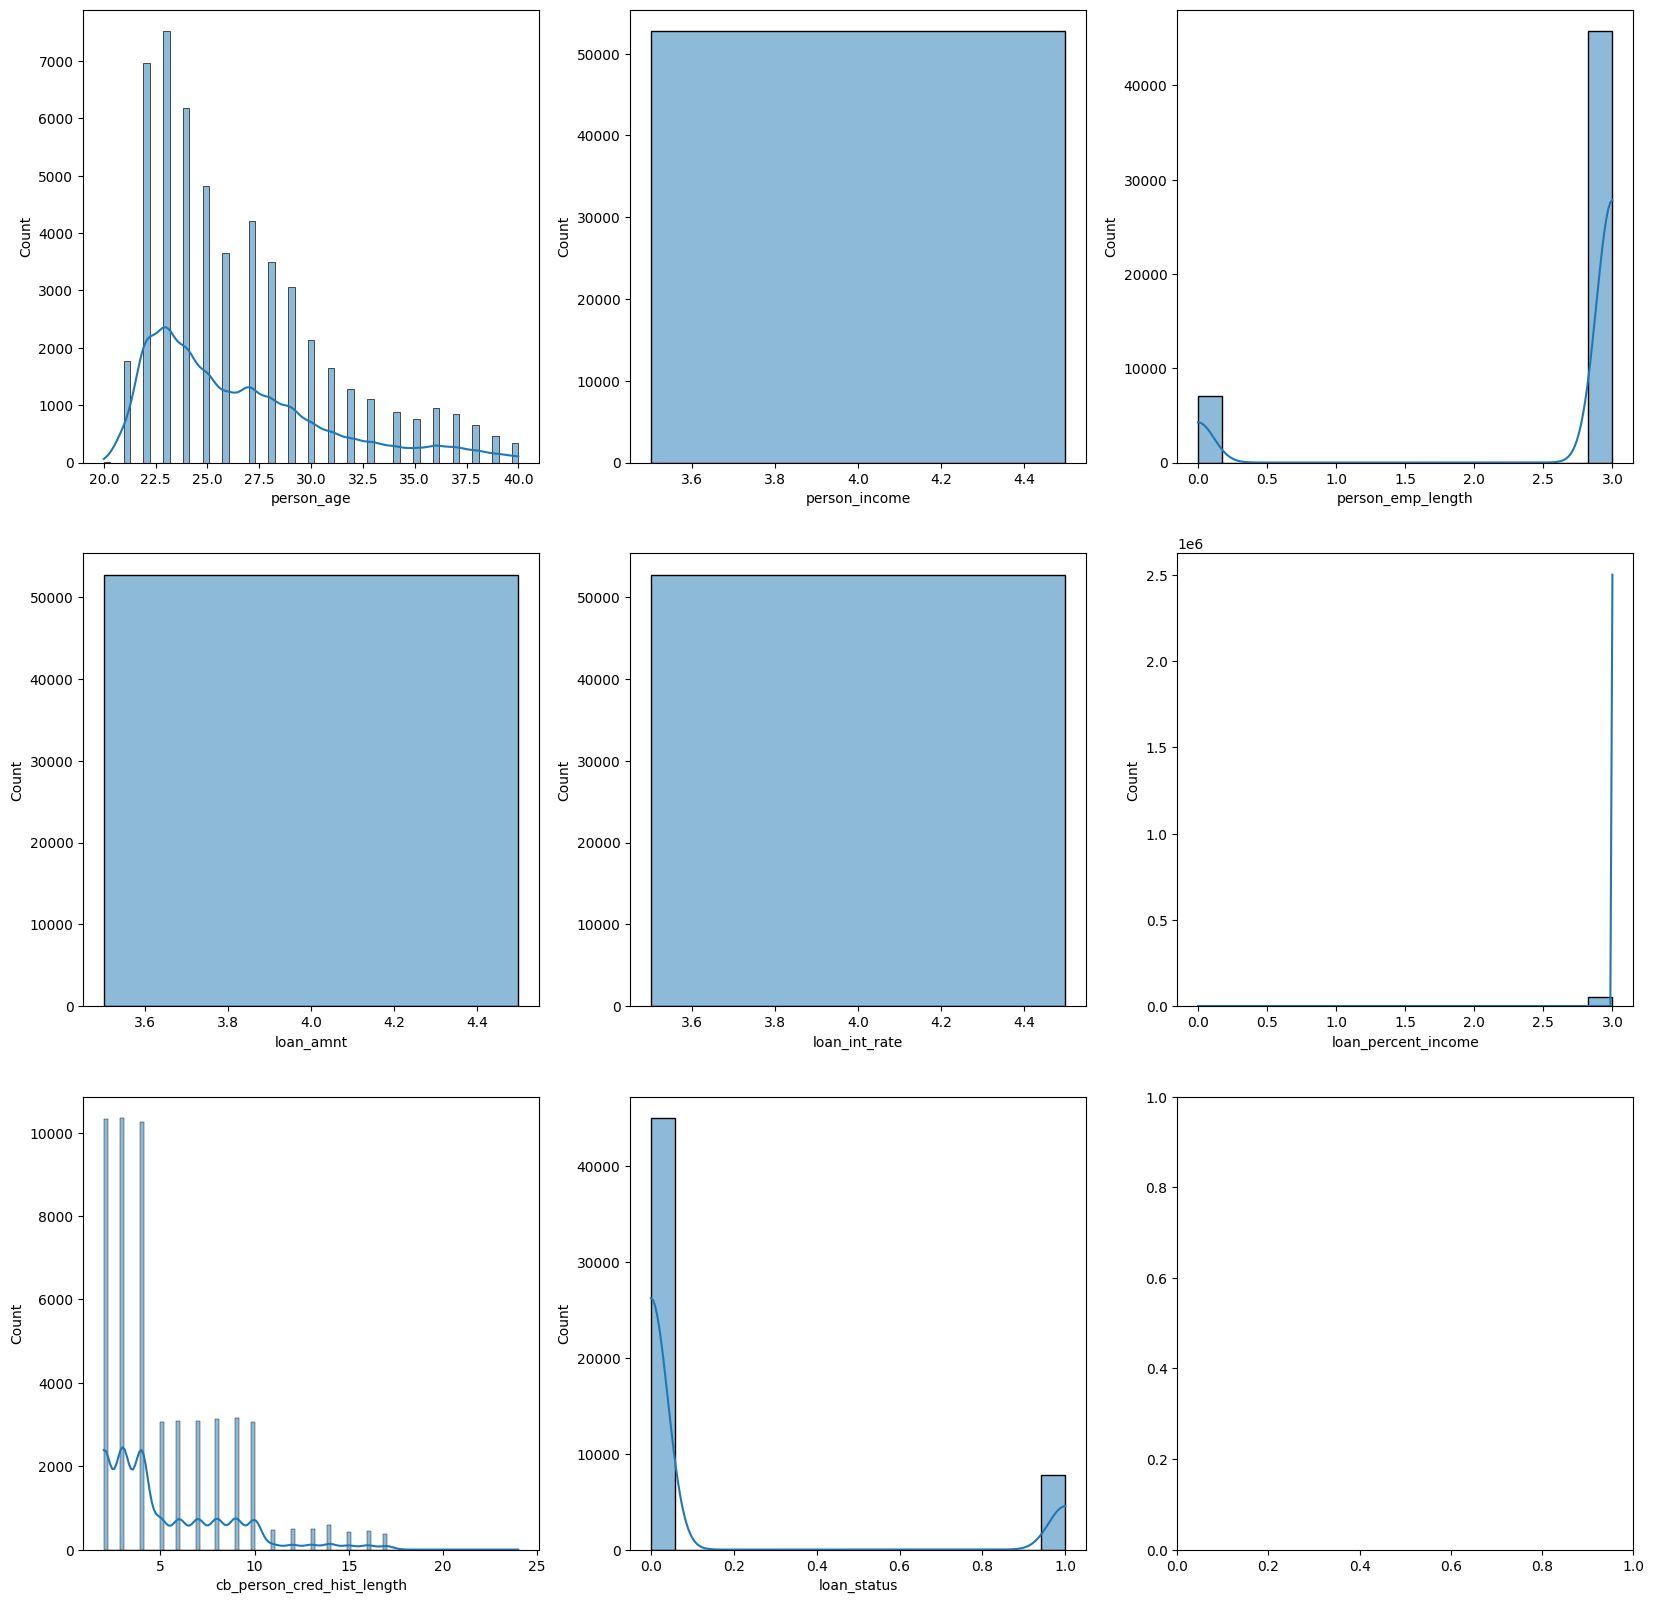

In [44]:
draw_hist_plots(a)

In [51]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocess_data(df, columns, method='z_score', transform='log', scale='standard'):
    """
    Preprocess the given DataFrame to handle outliers, skewness, and kurtosis.

    Parameters:
    - df: pd.DataFrame - Input DataFrame.
    - columns: list - List of column names to preprocess.
    - method: str - Method to identify outliers ('z_score' or 'IQR').
    - transform: str - Transformation to apply ('log', 'sqrt', 'boxcox', or 'none').
    - scale: str - Scaling method ('standard', 'minmax', or 'none').

    Returns:
    - pd.DataFrame - Preprocessed DataFrame.
    """
    # df[columns].info()
    df_copy = df.copy()

    # Step 1: Handle Outliers
    for column in columns:
        if method == 'z_score':
            # Identify outliers using Z-score
            z_scores = np.abs(stats.zscore(df_copy[column]))
            df_copy = df_copy[z_scores < 3]  # Adjust the threshold as needed
        elif method == 'IQR':
            # Identify outliers using IQR
            Q1 = df_copy[column].quantile(0.25)
            Q3 = df_copy[column].quantile(0.75)
            IQR = Q3 - Q1
            df_copy = df_copy[(df_copy[column] >= (Q1 - 1.5 * IQR)) & (df_copy[column] <= (Q3 + 1.5 * IQR))]

    # Step 2: Transform to Handle Skewness and Kurtosis
    for column in columns:
        if transform == 'log':
            df_copy[column] = np.log1p(df_copy[column])
        elif transform == 'sqrt':
            df_copy[column] = np.sqrt(df_copy[column])
        elif transform == 'boxcox':
            df_copy[column], _ = stats.boxcox(df_copy[column] + 1)  # Add 1 to avoid zero values
        elif transform == 'yeo-johnson':
            df_copy[column] = stats.yeojohnson(df_copy[column])[0]  # Yeo-Johnson transformation

    # Step 3: Scale the Data
    if scale == 'standard':
        scaler = StandardScaler()
        df_copy[columns] = scaler.fit_transform(df_copy[columns])
    elif scale == 'minmax':
        scaler = MinMaxScaler()
        df_copy[columns] = scaler.fit_transform(df_copy[columns])

    return df_copy

# Example usage
# df_cleaned = preprocess_data(df, ['person_age', 'person_income', 'loan_amnt'], method='IQR', transform='log', scale='standard')


In [53]:
df2 = preprocess_data(df,columns=['person_age', 'person_income', 
       'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 
       'cb_person_cred_hist_length'],method='IQR',transform='log',scale='standard')


In [74]:



import optuna

def hyper_tune_model(df,NUM_FOLD = 3,n_trials=50):
    cat_cols = list(df.select_dtypes(include=['object','category']).columns)
    
    for col in cat_cols:
        df[col] = df[col].astype('str').astype('category')

    X = df.drop(['loan_status'], axis=1)
    y = df['loan_status']

    X, _, y, _ = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)


    def objective_func(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 800, 1500),
            'depth': trial.suggest_int('depth', 2, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 10),
            'border_count': trial.suggest_int('border_count', 210, 350),
            'random_strength': trial.suggest_float('random_strength', 4,10),
            'bagging_temperature': trial.suggest_float('bagging_temperature',1,2),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 8),
            'verbose': False,
            'task_type': 'CPU',
        }


        skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=42)
        scores = []

        for train_idx, valid_idx in skf.split(X, y):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

            model = CatBoostClassifier(**params,cat_features=cat_cols)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)
            y_pred = model.predict_proba(X_valid)[:, 1]
            score = roc_auc_score(y_valid, y_pred)
            scores.append(score)

        return np.mean(scores)
    

    
    study = optuna.create_study(direction='maximize', study_name='catboost')
    study.optimize(objective_func, n_trials=n_trials)

    return study

In [75]:
study = hyper_tune_model(df2,NUM_FOLD=3,n_trials=50)


[I 2024-10-14 22:55:46,685] A new study created in memory with name: catboost
[I 2024-10-14 22:55:52,189] Trial 0 finished with value: 0.9300397222679359 and parameters: {'iterations': 997, 'depth': 4, 'learning_rate': 0.08765677776563603, 'l2_leaf_reg': 9.085124329737841, 'border_count': 325, 'random_strength': 6.714901890137265, 'bagging_temperature': 1.7584288042484086, 'scale_pos_weight': 2.7335028387395472}. Best is trial 0 with value: 0.9300397222679359.
[I 2024-10-14 22:55:55,325] Trial 1 finished with value: 0.9257929879550107 and parameters: {'iterations': 984, 'depth': 6, 'learning_rate': 0.08569880641502918, 'l2_leaf_reg': 8.627513368678015, 'border_count': 249, 'random_strength': 7.979870289164584, 'bagging_temperature': 1.0000996527547807, 'scale_pos_weight': 5.2475363608302885}. Best is trial 0 with value: 0.9300397222679359.
[I 2024-10-14 22:56:00,939] Trial 2 finished with value: 0.9305078705337712 and parameters: {'iterations': 1316, 'depth': 2, 'learning_rate': 0.0922

In [77]:
study.best_params, study.best_value

({'iterations': 1163,
  'depth': 3,
  'learning_rate': 0.08949685599289657,
  'l2_leaf_reg': 5.214556214831804,
  'border_count': 312,
  'random_strength': 9.09190186707244,
  'bagging_temperature': 1.7356283525565492,
  'scale_pos_weight': 3.3149338489511546},
 0.9321601199877497)

In [84]:

NUM_FOLD = 5

train = pd.read_csv('../dataset/train.csv', index_col='id')
test = pd.read_csv('../dataset/test.csv', index_col='id')
original = pd.read_csv('../dataset/original.csv')
sample_submission = pd.read_csv('../dataset/sample_submission.csv')

# accepted_cols = ['person_income', 'person_home_ownership', 'loan_intent',
#        'loan_grade', 'loan_int_rate', 'loan_percent_income','loan_status']

# train = train[accepted_cols]
# original = original[accepted_cols]
# accepted_cols.remove("loan_status")
# test = test[accepted_cols]

train = preprocess_data(train,columns=['person_age', 'person_income', 
       'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 
       'cb_person_cred_hist_length'],method='IQR',transform='log',scale='standard')
original = preprocess_data(original,columns=['person_age', 'person_income', 
       'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 
       'cb_person_cred_hist_length'],method='IQR',transform='log',scale='standard')


cat_cols = list(test.select_dtypes(include=['object','category']).columns)

for df in [train, test, original]:
    for col in cat_cols:
        df[col] = df[col].astype('str').astype('category')


X = train.drop(['loan_status'], axis=1)
y = train['loan_status']
X_original = original.drop(['loan_status'], axis=1)
y_original = original['loan_status']





In [85]:

val_scores = []
test_preds_model = []

skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=42)

params = {'iterations': 1163,
  'depth': 3,
  'learning_rate': 0.08949685599289657,
  'l2_leaf_reg': 5.214556214831804,
  'border_count': 312,
  'random_strength': 9.09190186707244,
  'bagging_temperature': 1.7356283525565492,
  'scale_pos_weight': 3.3149338489511546
  }

for Fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = pd.concat([X_train, X_original], axis=0)
    y_train = pd.concat([y_train, y_original]) 

    model = CatBoostClassifier(**params,cat_features=cat_cols)
    # model.fit(X_train, y_train)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict_proba(X_val)[:, 1]

    roc_auc_score_ = roc_auc_score(y_val, y_pred)

    print(f'Fold {Fold}: roc_auc_score= {roc_auc_score_:.5f}')

    val_scores.append(roc_auc_score_)

    test_preds_model.append(model.predict_proba(test)[:, 1])

test_preds_model = sum(test_preds_model)/len(test_preds_model)

print(f'mean validation roc_auc_score = {np.mean(val_scores):.5f}')
print(f'std validation roc_auc_score = {np.std(val_scores):.5f}')


KeyError: '[44, 57, 67, 78, 81, 83, 87, 91, 92, 100, 101, 104, 115, 129, 131, 132, 137, 144, 153, 154, 160, 184, 191, 204, 209, 218, 222, 224, 249, 251, 261, 262, 273, 281, 308, 311, 323, 324, 325, 337, 338, 347, 350, 351, 377, 384, 389, 403, 404, 407, 411, 414, 423, 425, 430, 434, 445, 450, 461, 464, 470, 471, 487, 488, 501, 503, 507, 513, 519, 525, 527, 533, 539, 547, 557, 570, 583, 597, 602, 607, 610, 615, 621, 637, 643, 644, 649, 652, 659, 660, 667, 671, 679, 689, 693, 699, 705, 711, 713, 716, 730, 744, 769, 770, 774, 776, 779, 792, 798, 804, 807, 808, 809, 811, 813, 824, 837, 847, 853, 868, 882, 884, 885, 906, 908, 922, 932, 934, 937, 943, 953, 960, 963, 969, 971, 975, 976, 978, 992, 1012, 1018, 1028, 1032, 1047, 1057, 1064, 1073, 1076, 1086, 1098, 1100, 1101, 1107, 1111, 1114, 1133, 1135, 1139, 1146, 1156, 1161, 1168, 1169, 1172, 1176, 1178, 1185, 1189, 1193, 1194, 1199, 1202, 1210, 1214, 1215, 1225, 1227, 1230, 1240, 1252, 1255, 1258, 1260, 1267, 1268, 1271, 1274, 1280, 1285, 1287, 1295, 1303, 1321, 1322, 1340, 1341, 1343, 1351, 1353, 1363, 1370, 1375, 1385, 1396, 1405, 1416, 1434, 1448, 1452, 1458, 1459, 1462, 1476, 1482, 1493, 1503, 1507, 1516, 1526, 1530, 1531, 1534, 1541, 1545, 1557, 1567, 1591, 1592, 1599, 1611, 1612, 1624, 1640, 1648, 1654, 1666, 1673, 1675, 1681, 1682, 1689, 1707, 1710, 1730, 1735, 1738, 1749, 1753, 1768, 1776, 1777, 1802, 1805, 1814, 1815, 1818, 1827, 1828, 1833, 1840, 1841, 1842, 1865, 1883, 1888, 1909, 1911, 1912, 1914, 1922, 1933, 1943, 1958, 1973, 1979, 1986, 1997, 2001, 2017, 2018, 2022, 2029, 2058, 2059, 2064, 2073, 2074, 2078, 2086, 2093, 2106, 2114, 2127, 2138, 2139, 2145, 2150, 2164, 2173, 2183, 2201, 2208, 2212, 2217, 2221, 2229, 2273, 2278, 2283, 2293, 2298, 2306, 2309, 2324, 2330, 2367, 2368, 2373, 2377, 2382, 2387, 2392, 2395, 2405, 2406, 2409, 2413, 2441, 2446, 2456, 2459, 2460, 2462, 2465, 2470, 2479, 2481, 2504, 2509, 2513, 2532, 2533, 2562, 2565, 2573, 2574, 2582, 2587, 2590, 2591, 2593, 2600, 2616, 2624, 2627, 2629, 2640, 2651, 2657, 2673, 2674, 2678, 2680, 2691, 2706, 2711, 2760, 2781, 2783, 2786, 2798, 2816, 2825, 2838, 2841, 2846, 2847, 2855, 2861, 2893, 2895, 2896, 2898, 2902, 2903, 2911, 2920, 2921, 2940, 2942, 2950, 2953, 2962, 2965, 2966, 2972, 2987, 2990, 2992, 2997, 3000, 3009, 3020, 3027, 3032, 3044, 3055, 3057, 3063, 3064, 3073, 3094, 3104, 3112, 3114, 3115, 3131, 3133, 3141, 3150, 3151, 3169, 3181, 3183, 3187, 3193, 3196, 3198, 3208, 3213, 3216, 3231, 3244, 3247, 3249, 3251, 3253, 3266, 3270, 3279, 3286, 3297, 3298, 3309, 3312, 3327, 3332, 3334, 3338, 3350, 3360, 3366, 3387, 3392, 3424, 3432, 3434, 3456, 3464, 3473, 3481, 3519, 3526, 3533, 3538, 3548, 3554, 3564, 3567, 3569, 3574, 3588, 3618, 3630, 3633, 3635, 3636, 3640, 3644, 3647, 3651, 3657, 3658, 3664, 3667, 3679, 3680, 3693, 3694, 3707, 3711, 3716, 3723, 3736, 3752, 3763, 3769, 3777, 3782, 3790, 3802, 3803, 3813, 3815, 3841, 3852, 3857, 3879, 3883, 3891, 3900, 3901, 3906, 3910, 3914, 3917, 3919, 3923, 3932, 3935, 3936, 3939, 3955, 3956, 3958, 3964, 3970, 3974, 3982, 3986, 3987, 3991, 3996, 4022, 4029, 4030, 4037, 4071, 4080, 4081, 4084, 4146, 4156, 4161, 4167, 4178, 4214, 4221, 4222, 4223, 4226, 4233, 4244, 4250, 4252, 4253, 4264, 4268, 4270, 4290, 4291, 4300, 4301, 4306, 4307, 4309, 4316, 4326, 4333, 4335, 4343, 4385, 4394, 4397, 4402, 4422, 4427, 4432, 4436, 4441, 4445, 4454, 4466, 4473, 4474, 4475, 4489, 4493, 4500, 4512, 4543, 4544, 4575, 4578, 4579, 4581, 4586, 4593, 4595, 4605, 4609, 4611, 4625, 4630, 4663, 4664, 4666, 4668, 4670, 4681, 4690, 4693, 4704, 4706, 4713, 4743, 4757, 4758, 4766, 4770, 4776, 4791, 4795, 4837, 4839, 4840, 4842, 4843, 4846, 4853, 4869, 4871, 4872, 4896, 4897, 4898, 4900, 4912, 4913, 4919, 4922, 4924, 4932, 4946, 4961, 4963, 4983, 4989, 4991, 4993, 4996, 4999, 5009, 5024, 5037, 5042, 5046, 5056, 5075, 5080, 5085, 5089, 5098, 5103, 5107, 5113, 5120, 5123, 5126, 5138, 5141, 5149, 5157, 5189, 5195, 5198, 5212, 5214, 5221, 5223, 5229, 5241, 5270, 5291, 5301, 5304, 5307, 5313, 5315, 5317, 5318, 5319, 5323, 5329, 5333, 5338, 5344, 5346, 5353, 5365, 5367, 5378, 5385, 5397, 5415, 5420, 5423, 5432, 5437, 5439, 5443, 5449, 5458, 5461, 5473, 5483, 5488, 5490, 5492, 5498, 5500, 5502, 5511, 5516, 5535, 5537, 5544, 5560, 5561, 5565, 5571, 5578, 5585, 5589, 5593, 5597, 5604, 5614, 5616, 5644, 5656, 5674, 5681, 5690, 5696, 5697, 5698, 5708, 5710, 5724, 5726, 5727, 5747, 5757, 5762, 5773, 5775, 5822, 5827, 5833, 5841, 5843, 5845, 5854, 5877, 5879, 5903, 5911, 5920, 5921, 5937, 5942, 5945, 5946, 5950, 5967, 5971, 5972, 5975, 5984, 5990, 5996, 5997, 6005, 6006, 6009, 6022, 6023, 6025, 6031, 6038, 6043, 6047, 6066, 6099, 6101, 6112, 6124, 6129, 6143, 6154, 6159, 6169, 6171, 6175, 6177, 6181, 6182, 6183, 6202, 6240, 6254, 6260, 6261, 6262, 6265, 6266, 6279, 6280, 6281, 6284, 6288, 6291, 6295, 6305, 6309, 6316, 6331, 6355, 6357, 6358, 6360, 6361, 6366, 6371, 6387, 6389, 6396, 6404, 6406, 6408, 6417, 6420, 6436, 6446, 6459, 6460, 6468, 6474, 6500, 6510, 6524, 6527, 6529, 6531, 6536, 6545, 6549, 6552, 6558, 6569, 6576, 6579, 6583, 6624, 6626, 6630, 6631, 6635, 6638, 6651, 6652, 6654, 6656, 6683, 6690, 6692, 6701, 6713, 6714, 6717, 6729, 6731, 6732, 6741, 6750, 6752, 6763, 6771, 6776, 6779, 6782, 6791, 6796, 6803, 6805, 6807, 6820, 6827, 6833, 6838, 6850, 6857, 6858, 6862, 6867, 6877, 6893, 6903, 6908, 6913, 6915, 6934, 6953, 6956, 6959, 6960, 6965, 6977, 6986, 6990, 6992, 7008, 7011, 7013, 7017, 7019, 7023, 7036, 7037, 7041, 7044, 7054, 7056, 7061, 7065, 7067, 7072, 7073, 7074, 7078, 7086, 7090, 7097, 7100, 7106, 7112, 7120, 7126, 7129, 7134, 7171, 7180, 7195, 7215, 7227, 7228, 7235, 7254, 7271, 7302, 7304, 7305, 7308, 7314, 7317, 7318, 7324, 7335, 7346, 7354, 7365, 7369, 7388, 7400, 7403, 7412, 7413, 7426, 7429, 7430, 7440, 7453, 7454, 7455, 7456, 7459, 7462, 7463, 7472, 7473, 7487, 7488, 7504, 7530, 7536, 7537, 7543, 7544, 7560, 7568, 7570, 7571, 7587, 7591, 7598, 7602, 7607, 7610, 7624, 7636, 7637, 7643, 7644, 7648, 7654, 7685, 7687, 7690, 7712, 7722, 7728, 7741, 7758, 7768, 7772, 7775, 7790, 7812, 7813, 7815, 7816, 7820, 7829, 7832, 7860, 7867, 7868, 7882, 7889, 7890, 7891, 7902, 7922, 7925, 7930, 7938, 7942, 7945, 7951, 7956, 7972, 7973, 8006, 8011, 8015, 8022, 8036, 8037, 8038, 8076, 8097, 8103, 8108, 8123, 8128, 8140, 8151, 8159, 8163, 8176, 8180, 8181, 8194, 8200, 8208, 8230, 8235, 8236, 8240, 8241, 8257, 8258, 8269, 8279, 8282, 8289, 8292, 8304, 8309, 8324, 8328, 8334, 8343, 8360, 8372, 8378, 8379, 8386, 8395, 8402, 8415, 8419, 8420, 8428, 8446, 8447, 8449, 8453, 8454, 8469, 8501, 8503, 8506, 8508, 8509, 8511, 8515, 8521, 8527, 8528, 8534, 8537, 8541, 8543, 8547, 8548, 8585, 8599, 8604, 8618, 8631, 8669, 8672, 8683, 8688, 8697, 8705, 8709, 8716, 8719, 8722, 8726, 8729, 8733, 8737, 8745, 8750, 8751, 8754, 8758, 8781, 8786, 8791, 8794, 8810, 8815, 8817, 8821, 8822, 8837, 8839, 8854, 8867, 8869, 8877, 8879, 8880, 8908, 8909, 8918, 8924, 8933, 8946, 8954, 8955, 8958, 8964, 8968, 8985, 8999, 9000, 9014, 9030, 9034, 9059, 9078, 9080, 9093, 9107, 9110, 9112, 9114, 9116, 9122, 9129, 9131, 9136, 9147, 9173, 9174, 9177, 9179, 9194, 9200, 9208, 9217, 9229, 9234, 9235, 9248, 9249, 9252, 9253, 9274, 9275, 9286, 9292, 9302, 9313, 9329, 9353, 9356, 9361, 9376, 9384, 9427, 9431, 9445, 9463, 9464, 9466, 9479, 9485, 9488, 9506, 9509, 9515, 9518, 9520, 9536, 9537, 9542, 9555, 9556, 9558, 9561, 9565, 9571, 9575, 9577, 9594, 9605, 9613, 9618, 9619, 9626, 9630, 9634, 9657, 9662, 9664, 9666, 9672, 9687, 9688, 9701, 9704, 9711, 9714, 9722, 9726, 9727, 9733, 9743, 9748, 9751, 9756, 9757, 9765, 9767, 9776, 9784, 9794, 9806, 9810, 9814, 9817, 9822, 9824, 9832, 9848, 9869, 9890, 9892, 9893, 9898, 9908, 9918, 9927, 9942, 9946, 9953, 9961, 9965, 9981, 9992, 9997, 10003, 10004, 10007, 10014, 10015, 10051, 10069, 10075, 10086, 10093, 10095, 10100, 10110, 10120, 10135, 10138, 10142, 10144, 10148, 10166, 10170, 10174, 10179, 10183, 10186, 10196, 10211, 10219, 10220, 10221, 10226, 10229, 10242, 10269, 10287, 10300, 10301, 10304, 10308, 10317, 10320, 10321, 10330, 10346, 10360, 10361, 10371, 10372, 10397, 10401, 10405, 10408, 10409, 10415, 10416, 10430, 10431, 10436, 10437, 10438, 10454, 10463, 10464, 10475, 10483, 10506, 10512, 10520, 10521, 10529, 10543, 10558, 10564, 10568, 10569, 10572, 10573, 10575, 10577, 10596, 10597, 10601, 10604, 10608, 10617, 10622, 10633, 10634, 10641, 10642, 10649, 10651, 10656, 10659, 10662, 10673, 10687, 10695, 10716, 10720, 10725, 10727, 10733, 10734, 10742, 10743, 10748, 10755, 10757, 10759, 10764, 10766, 10774, 10778, 10780, 10781, 10783, 10784, 10790, 10809, 10812, 10816, 10819, 10821, 10832, 10843, 10844, 10846, 10848, 10856, 10860, 10866, 10867, 10871, 10895, 10905, 10922, 10929, 10931, 10934, 10945, 10952, 10958, 10981, 10985, 10997, 11000, 11005, 11010, 11011, 11029, 11042, 11045, 11057, 11068, 11081, 11083, 11084, 11119, 11123, 11136, 11138, 11140, 11150, 11152, 11154, 11157, 11161, 11163, 11165, 11170, 11172, 11183, 11193, 11196, 11197, 11200, 11235, 11243, 11256, 11257, 11270, 11273, 11298, 11300, 11308, 11332, 11363, 11375, 11386, 11394, 11406, 11410, 11421, 11422, 11423, 11438, 11442, 11455, 11458, 11466, 11467, 11468, 11493, 11511, 11514, 11548, 11550, 11554, 11574, 11589, 11601, 11614, 11619, 11620, 11621, 11622, 11634, 11638, 11643, 11647, 11651, 11653, 11668, 11669, 11679, 11686, 11689, 11700, 11704, 11712, 11714, 11727, 11728, 11741, 11743, 11745, 11746, 11749, 11751, 11752, 11768, 11770, 11779, 11782, 11784, 11794, 11795, 11797, 11825, 11828, 11835, 11839, 11860, 11870, 11873, 11879, 11883, 11899, 11906, 11923, 11927, 11969, 11971, 11973, 11975, 11976, 11977, 11981, 11990, 11992, 11999, 12015, 12033, 12036, 12055, 12068, 12072, 12075, 12086, 12087, 12093, 12099, 12109, 12113, 12116, 12117, 12121, 12142, 12154, 12155, 12164, 12175, 12176, 12180, 12189, 12201, 12202, 12212, 12222, 12228, 12263, 12281, 12288, 12289, 12301, 12318, 12319, 12338, 12347, 12348, 12360, 12365, 12367, 12376, 12377, 12380, 12397, 12404, 12416, 12417, 12426, 12428, 12432, 12438, 12447, 12452, 12465, 12485, 12487, 12498, 12501, 12526, 12537, 12539, 12541, 12545, 12568, 12576, 12583, 12584, 12592, 12610, 12612, 12628, 12632, 12638, 12642, 12659, 12674, 12676, 12678, 12693, 12697, 12698, 12699, 12721, 12729, 12733, 12740, 12743, 12745, 12770, 12777, 12799, 12800, 12805, 12812, 12813, 12821, 12824, 12826, 12831, 12832, 12841, 12843, 12844, 12871, 12877, 12880, 12882, 12894, 12895, 12906, 12907, 12908, 12910, 12919, 12920, 12924, 12957, 12965, 12970, 12977, 12979, 12988, 12992, 12993, 12994, 13019, 13021, 13022, 13030, 13033, 13034, 13045, 13050, 13069, 13074, 13089, 13105, 13121, 13125, 13126, 13136, 13137, 13139, 13146, 13153, 13187, 13198, 13208, 13214, 13216, 13221, 13226, 13228, 13248, 13254, 13267, 13294, 13322, 13323, 13328, 13331, 13332, 13336, 13344, 13348, 13367, 13372, 13381, 13386, 13398, 13399, 13420, 13424, 13425, 13426, 13431, 13436, 13441, 13463, 13465, 13469, 13471, 13475, 13497, 13499, 13502, 13507, 13522, 13536, 13543, 13547, 13549, 13555, 13557, 13563, 13567, 13579, 13583, 13586, 13595, 13607, 13617, 13619, 13627, 13628, 13629, 13632, 13639, 13651, 13666, 13668, 13672, 13678, 13680, 13681, 13699, 13703, 13710, 13714, 13719, 13722, 13727, 13735, 13738, 13743, 13744, 13754, 13758, 13763, 13773, 13774, 13781, 13782, 13794, 13805, 13812, 13822, 13825, 13828, 13829, 13838, 13840, 13851, 13875, 13878, 13881, 13883, 13891, 13893, 13899, 13917, 13920, 13921, 13938, 13941, 13954, 13956, 13958, 13961, 13970, 13980, 13994, 13995, 14017, 14019, 14028, 14030, 14034, 14037, 14044, 14052, 14055, 14060, 14066, 14069, 14080, 14085, 14088, 14092, 14093, 14098, 14116, 14135, 14138, 14139, 14164, 14179, 14185, 14187, 14188, 14216, 14220, 14232, 14233, 14237, 14240, 14243, 14245, 14248, 14251, 14253, 14255, 14256, 14272, 14279, 14280, 14298, 14299, 14300, 14306, 14309, 14316, 14336, 14337, 14338, 14339, 14340, 14348, 14352, 14358, 14361, 14364, 14373, 14381, 14385, 14396, 14416, 14417, 14419, 14425, 14426, 14428, 14429, 14433, 14437, 14445, 14449, 14452, 14459, 14468, 14471, 14483, 14486, 14488, 14489, 14492, 14495, 14507, 14511, 14513, 14514, 14517, 14518, 14521, 14546, 14560, 14565, 14575, 14578, 14591, 14597, 14612, 14639, 14642, 14648, 14653, 14661, 14670, 14673, 14684, 14689, 14691, 14694, 14703, 14726, 14729, 14730, 14752, 14774, 14776, 14779, 14780, 14792, 14805, 14809, 14812, 14819, 14829, 14840, 14858, 14860, 14861, 14864, 14876, 14888, 14898, 14914, 14916, 14956, 14966, 14985, 14987, 14997, 14999, 15000, 15006, 15014, 15020, 15025, 15028, 15037, 15056, 15060, 15062, 15067, 15073, 15076, 15088, 15098, 15114, 15115, 15120, 15130, 15132, 15145, 15147, 15148, 15169, 15173, 15177, 15180, 15182, 15186, 15200, 15202, 15203, 15227, 15228, 15231, 15251, 15252, 15259, 15266, 15268, 15269, 15272, 15279, 15280, 15289, 15309, 15318, 15323, 15326, 15330, 15333, 15340, 15344, 15350, 15351, 15368, 15401, 15411, 15412, 15422, 15426, 15429, 15434, 15439, 15440, 15441, 15455, 15457, 15460, 15468, 15476, 15477, 15480, 15485, 15486, 15499, 15510, 15516, 15519, 15524, 15547, 15553, 15558, 15559, 15565, 15566, 15577, 15578, 15581, 15587, 15588, 15598, 15605, 15622, 15630, 15636, 15638, 15654, 15656, 15674, 15679, 15680, 15692, 15704, 15717, 15719, 15729, 15745, 15749, 15769, 15781, 15782, 15784, 15796, 15833, 15836, 15844, 15847, 15849, 15862, 15873, 15889, 15899, 15901, 15911, 15915, 15916, 15918, 15920, 15922, 15928, 15937, 15946, 15949, 15958, 15962, 15972, 15981, 15987, 15995, 16020, 16022, 16027, 16035, 16040, 16046, 16051, 16052, 16053, 16055, 16060, 16067, 16072, 16100, 16107, 16108, 16110, 16123, 16129, 16131, 16161, 16164, 16169, 16183, 16189, 16192, 16196, 16198, 16199, 16205, 16209, 16210, 16211, 16215, 16229, 16240, 16253, 16260, 16267, 16288, 16294, 16295, 16297, 16300, 16326, 16338, 16340, 16352, 16367, 16381, 16385, 16405, 16412, 16433, 16436, 16439, 16442, 16443, 16447, 16449, 16454, 16457, 16470, 16487, 16489, 16491, 16493, 16500, 16501, 16502, 16510, 16511, 16530, 16533, 16538, 16539, 16544, 16547, 16548, 16555, 16563, 16564, 16569, 16573, 16588, 16592, 16614, 16619, 16629, 16638, 16668, 16669, 16677, 16683, 16684, 16699, 16709, 16721, 16734, 16735, 16755, 16762, 16768, 16770, 16786, 16790, 16792, 16805, 16819, 16822, 16834, 16848, 16859, 16861, 16862, 16863, 16871, 16874, 16898, 16901, 16903, 16932, 16934, 16944, 16949, 16951, 16954, 16955, 16958, 16959, 16967, 16976, 16981, 16991, 16997, 17013, 17023, 17024, 17030, 17032, 17043, 17062, 17073, 17080, 17086, 17088, 17106, 17110, 17119, 17126, 17130, 17142, 17154, 17166, 17172, 17191, 17194, 17198, 17206, 17207, 17219, 17222, 17237, 17245, 17253, 17260, 17264, 17268, 17273, 17275, 17285, 17290, 17331, 17366, 17367, 17372, 17384, 17385, 17386, 17388, 17389, 17395, 17405, 17407, 17412, 17413, 17417, 17419, 17428, 17431, 17432, 17437, 17438, 17442, 17446, 17448, 17459, 17468, 17478, 17482, 17483, 17486, 17495, 17501, 17542, 17547, 17553, 17554, 17556, 17557, 17561, 17570, 17572, 17583, 17599, 17602, 17604, 17615, 17617, 17620, 17627, 17629, 17635, 17639, 17640, 17646, 17654, 17674, 17679, 17680, 17683, 17700, 17701, 17703, 17708, 17709, 17713, 17719, 17728, 17731, 17755, 17773, 17777, 17781, 17787, 17796, 17799, 17800, 17805, 17814, 17824, 17829, 17832, 17842, 17851, 17855, 17861, 17862, 17879, 17892, 17901, 17920, 17929, 17938, 17953, 17963, 17971, 17975, 17977, 17979, 17989, 17998, 18002, 18007, 18015, 18022, 18034, 18035, 18038, 18040, 18048, 18052, 18073, 18078, 18085, 18090, 18099, 18100, 18102, 18104, 18110, 18112, 18117, 18125, 18141, 18167, 18172, 18180, 18195, 18199, 18207, 18215, 18223, 18252, 18253, 18254, 18278, 18284, 18287, 18288, 18291, 18310, 18312, 18314, 18316, 18322, 18324, 18327, 18339, 18347, 18350, 18360, 18362, 18364, 18365, 18370, 18377, 18380, 18392, 18401, 18408, 18410, 18414, 18418, 18428, 18429, 18437, 18441, 18454, 18465, 18468, 18476, 18481, 18496, 18504, 18515, 18526, 18534, 18540, 18543, 18553, 18557, 18575, 18588, 18592, 18602, 18612, 18625, 18626, 18631, 18642, 18651, 18665, 18677, 18685, 18689, 18698, 18707, 18710, 18711, 18723, 18734, 18736, 18744, 18760, 18761, 18763, 18770, 18782, 18786, 18788, 18796, 18799, 18800, 18801, 18821, 18827, 18834, 18837, 18852, 18853, 18858, 18862, 18865, 18866, 18879, 18894, 18900, 18905, 18906, 18910, 18911, 18915, 18934, 18945, 18947, 18951, 18952, 18957, 18958, 18961, 18973, 18982, 18990, 19004, 19006, 19015, 19028, 19032, 19039, 19060, 19063, 19083, 19096, 19098, 19102, 19109, 19117, 19125, 19130, 19131, 19141, 19147, 19159, 19168, 19169, 19178, 19180, 19190, 19191, 19208, 19221, 19230, 19237, 19250, 19252, 19263, 19265, 19288, 19289, 19294, 19304, 19315, 19318, 19328, 19331, 19348, 19350, 19354, 19364, 19369, 19371, 19384, 19385, 19391, 19398, 19400, 19405, 19413, 19414, 19440, 19455, 19457, 19459, 19464, 19473, 19480, 19484, 19485, 19488, 19493, 19498, 19505, 19524, 19529, 19534, 19543, 19552, 19555, 19566, 19571, 19586, 19592, 19595, 19612, 19626, 19635, 19636, 19637, 19652, 19660, 19664, 19665, 19669, 19671, 19680, 19684, 19704, 19705, 19709, 19710, 19712, 19719, 19727, 19730, 19731, 19741, 19749, 19758, 19763, 19767, 19773, 19780, 19784, 19794, 19797, 19802, 19804, 19807, 19820, 19829, 19835, 19839, 19841, 19853, 19857, 19859, 19874, 19906, 19934, 19935, 19937, 19943, 19945, 19946, 19967, 19975, 19976, 19984, 19985, 19990, 19991, 19998, 20023, 20027, 20035, 20048, 20050, 20060, 20061, 20062, 20073, 20075, 20098, 20100, 20111, 20120, 20128, 20141, 20143, 20146, 20148, 20160, 20163, 20164, 20169, 20190, 20193, 20199, 20206, 20215, 20216, 20217, 20222, 20224, 20237, 20246, 20250, 20255, 20256, 20258, 20259, 20264, 20271, 20276, 20287, 20292, 20299, 20307, 20310, 20312, 20317, 20319, 20329, 20348, 20352, 20362, 20364, 20368, 20373, 20380, 20381, 20384, 20388, 20391, 20402, 20403, 20404, 20405, 20409, 20432, 20450, 20455, 20458, 20465, 20472, 20480, 20486, 20499, 20510, 20513, 20522, 20528, 20539, 20540, 20546, 20549, 20572, 20593, 20594, 20628, 20636, 20638, 20666, 20671, 20673, 20676, 20690, 20701, 20711, 20713, 20720, 20721, 20729, 20737, 20797, 20800, 20805, 20811, 20812, 20828, 20832, 20869, 20880, 20891, 20896, 20905, 20924, 20927, 20929, 20930, 20934, 20938, 20939, 20949, 20951, 20953, 20958, 20961, 20969, 20977, 20978, 20979, 20987, 20990, 20992, 20998, 21016, 21020, 21029, 21031, 21050, 21054, 21065, 21071, 21073, 21090, 21100, 21111, 21114, 21139, 21162, 21172, 21175, 21185, 21188, 21194, 21207, 21213, 21218, 21219, 21220, 21237, 21238, 21263, 21267, 21286, 21289, 21290, 21292, 21297, 21301, 21313, 21321, 21325, 21332, 21341, 21343, 21357, 21380, 21387, 21388, 21394, 21409, 21415, 21418, 21428, 21433, 21437, 21443, 21445, 21472, 21478, 21481, 21483, 21486, 21492, 21493, 21498, 21504, 21515, 21522, 21532, 21535, 21539, 21540, 21554, 21556, 21561, 21569, 21574, 21581, 21589, 21591, 21597, 21604, 21607, 21609, 21621, 21656, 21668, 21673, 21689, 21693, 21703, 21721, 21725, 21726, 21739, 21744, 21745, 21747, 21749, 21766, 21770, 21772, 21778, 21790, 21799, 21800, 21806, 21825, 21827, 21837, 21838, 21857, 21872, 21898, 21899, 21903, 21906, 21915, 21926, 21933, 21943, 21952, 21953, 21958, 21966, 21967, 21980, 21982, 21989, 22002, 22006, 22008, 22018, 22022, 22032, 22046, 22051, 22061, 22071, 22077, 22081, 22088, 22092, 22093, 22097, 22101, 22109, 22115, 22121, 22123, 22124, 22126, 22146, 22156, 22168, 22174, 22175, 22177, 22197, 22198, 22203, 22217, 22228, 22229, 22232, 22236, 22267, 22268, 22286, 22293, 22296, 22300, 22303, 22315, 22318, 22325, 22326, 22328, 22334, 22340, 22345, 22350, 22358, 22359, 22370, 22378, 22392, 22398, 22400, 22429, 22438, 22454, 22455, 22484, 22492, 22493, 22495, 22498, 22499, 22506, 22515, 22527, 22534, 22543, 22559, 22567, 22582, 22586, 22593, 22628, 22636, 22638, 22643, 22647, 22662, 22674, 22684, 22691, 22699, 22702, 22708, 22731, 22732, 22740, 22750, 22754, 22757, 22761, 22762, 22763, 22769, 22776, 22781, 22783, 22787, 22790, 22796, 22799, 22824, 22830, 22833, 22845, 22848, 22858, 22893, 22896, 22904, 22905, 22910, 22912, 22935, 22938, 22939, 22949, 22952, 22976, 22977, 22980, 22987, 22994, 23005, 23016, 23018, 23023, 23026, 23041, 23048, 23090, 23111, 23133, 23141, 23149, 23157, 23158, 23162, 23174, 23203, 23206, 23211, 23212, 23219, 23222, 23246, 23258, 23265, 23276, 23280, 23283, 23286, 23290, 23293, 23326, 23339, 23341, 23344, 23345, 23346, 23347, 23350, 23352, 23357, 23365, 23387, 23388, 23389, 23391, 23397, 23399, 23405, 23409, 23435, 23436, 23437, 23449, 23459, 23470, 23474, 23478, 23489, 23491, 23492, 23494, 23495, 23500, 23509, 23515, 23535, 23537, 23538, 23542, 23547, 23555, 23557, 23561, 23569, 23572, 23577, 23594, 23613, 23617, 23620, 23622, 23625, 23629, 23636, 23642, 23648, 23649, 23660, 23661, 23671, 23678, 23683, 23689, 23699, 23710, 23712, 23725, 23732, 23734, 23743, 23746, 23755, 23769, 23793, 23802, 23808, 23813, 23817, 23823, 23825, 23859, 23861, 23864, 23873, 23878, 23882, 23883, 23890, 23900, 23902, 23905, 23906, 23917, 23924, 23930, 23939, 23959, 23963, 23966, 23968, 23976, 23978, 23984, 23986, 24015, 24023, 24034, 24043, 24046, 24047, 24065, 24082, 24091, 24093, 24100, 24103, 24110, 24135, 24149, 24152, 24156, 24159, 24167, 24171, 24183, 24189, 24198, 24214, 24215, 24221, 24222, 24231, 24254, 24258, 24261, 24266, 24270, 24274, 24276, 24279, 24295, 24301, 24304, 24305, 24320, 24325, 24332, 24333, 24335, 24343, 24350, 24351, 24360, 24368, 24378, 24381, 24389, 24399, 24404, 24406, 24414, 24422, 24425, 24437, 24441, 24449, 24462, 24467, 24479, 24482, 24487, 24491, 24499, 24503, 24520, 24536, 24539, 24549, 24553, 24555, 24561, 24566, 24568, 24573, 24574, 24580, 24581, 24584, 24586, 24588, 24610, 24615, 24616, 24640, 24641, 24643, 24650, 24653, 24654, 24660, 24665, 24667, 24672, 24679, 24686, 24692, 24702, 24742, 24747, 24758, 24789, 24797, 24802, 24803, 24804, 24807, 24816, 24829, 24837, 24840, 24841, 24847, 24863, 24869, 24870, 24871, 24876, 24877, 24894, 24898, 24907, 24908, 24910, 24911, 24912, 24916, 24917, 24921, 24935, 24938, 24943, 24945, 24975, 24990, 24998, 25003, 25024, 25030, 25037, 25052, 25063, 25090, 25095, 25102, 25116, 25118, 25123, 25128, 25129, 25135, 25137, 25152, 25157, 25162, 25163, 25165, 25174, 25175, 25186, 25187, 25194, 25197, 25202, 25223, 25227, 25238, 25246, 25259, 25267, 25275, 25282, 25283, 25290, 25314, 25322, 25332, 25333, 25334, 25335, 25353, 25357, 25360, 25363, 25366, 25372, 25400, 25411, 25417, 25425, 25429, 25436, 25461, 25469, 25472, 25478, 25482, 25487, 25488, 25490, 25497, 25499, 25506, 25513, 25518, 25524, 25530, 25539, 25548, 25559, 25568, 25587, 25590, 25600, 25601, 25609, 25612, 25615, 25619, 25630, 25631, 25640, 25641, 25646, 25652, 25654, 25658, 25662, 25665, 25670, 25680, 25683, 25688, 25689, 25694, 25750, 25759, 25780, 25782, 25795, 25806, 25814, 25815, 25823, 25824, 25832, 25837, 25839, 25841, 25854, 25862, 25870, 25871, 25876, 25878, 25881, 25893, 25896, 25913, 25924, 25925, 25927, 25929, 25934, 25941, 25966, 25967, 25974, 25986, 25991, 26002, 26012, 26025, 26027, 26030, 26039, 26049, 26051, 26069, 26070, 26072, 26073, 26076, 26087, 26090, 26095, 26109, 26114, 26121, 26125, 26131, 26134, 26136, 26143, 26155, 26171, 26172, 26173, 26181, 26184, 26187, 26198, 26207, 26212, 26221, 26222, 26223, 26224, 26230, 26250, 26253, 26273, 26285, 26290, 26292, 26304, 26307, 26332, 26340, 26348, 26355, 26364, 26379, 26386, 26392, 26399, 26404, 26410, 26422, 26446, 26454, 26457, 26460, 26468, 26469, 26474, 26487, 26492, 26500, 26501, 26519, 26528, 26530, 26551, 26554, 26567, 26573, 26578, 26587, 26589, 26593, 26607, 26621, 26624, 26626, 26634, 26640, 26643, 26645, 26650, 26663, 26664, 26665, 26666, 26674, 26675, 26679, 26683, 26704, 26715, 26736, 26746, 26748, 26752, 26754, 26757, 26764, 26773, 26787, 26800, 26801, 26804, 26810, 26826, 26831, 26839, 26865, 26868, 26881, 26890, 26892, 26902, 26911, 26915, 26919, 26921, 26923, 26932, 26934, 26953, 26955, 26967, 26969, 26970, 26981, 26990, 26992, 26997, 27007, 27011, 27023, 27028, 27045, 27046, 27047, 27048, 27049, 27055, 27072, 27074, 27075, 27080, 27089, 27098, 27099, 27119, 27123, 27129, 27140, 27143, 27164, 27170, 27171, 27187, 27190, 27193, 27198, 27201, 27217, 27219, 27225, 27234, 27243, 27250, 27255, 27268, 27270, 27272, 27282, 27298, 27309, 27318, 27327, 27359, 27364, 27369, 27371, 27382, 27385, 27399, 27410, 27425, 27426, 27434, 27436, 27447, 27450, 27452, 27459, 27460, 27464, 27475, 27479, 27482, 27484, 27498, 27509, 27512, 27514, 27515, 27519, 27520, 27535, 27545, 27548, 27550, 27577, 27599, 27601, 27608, 27609, 27628, 27630, 27645, 27658, 27664, 27665, 27673, 27674, 27680, 27701, 27709, 27711, 27714, 27717, 27732, 27741, 27761, 27777, 27781, 27809, 27811, 27817, 27825, 27827, 27829, 27834, 27861, 27867, 27868, 27869, 27877, 27880, 27888, 27891, 27911, 27916, 27924, 27927, 27928, 27932, 27934, 27937, 27943, 27951, 27954, 27955, 27964, 27990, 28024, 28032, 28053, 28059, 28062, 28072, 28075, 28084, 28085, 28088, 28094, 28101, 28115, 28130, 28131, 28149, 28176, 28177, 28192, 28195, 28201, 28210, 28223, 28228, 28234, 28246, 28250, 28251, 28256, 28264, 28292, 28306, 28308, 28314, 28321, 28328, 28340, 28350, 28352, 28354, 28355, 28361, 28373, 28379, 28382, 28400, 28408, 28416, 28420, 28423, 28432, 28437, 28440, 28450, 28465, 28473, 28482, 28494, 28504, 28509, 28519, 28521, 28539, 28541, 28543, 28549, 28559, 28579, 28585, 28592, 28593, 28595, 28605, 28615, 28617, 28621, 28622, 28626, 28648, 28650, 28651, 28659, 28684, 28688, 28691, 28692, 28695, 28698, 28699, 28701, 28704, 28720, 28722, 28750, 28757, 28759, 28764, 28770, 28785, 28793, 28803, 28806, 28807, 28817, 28818, 28819, 28823, 28824, 28825, 28836, 28840, 28844, 28845, 28847, 28853, 28856, 28858, 28868, 28873, 28875, 28876, 28878, 28886, 28892, 28895, 28897, 28909, 28917, 28922, 28943, 28962, 28981, 28990, 28995, 29011, 29016, 29021, 29024, 29031, 29040, 29041, 29044, 29048, 29056, 29067, 29072, 29076, 29084, 29088, 29100, 29101, 29105, 29107, 29108, 29116, 29138, 29149, 29161, 29171, 29193, 29199, 29210, 29226, 29232, 29235, 29241, 29243, 29271, 29275, 29281, 29288, 29295, 29298, 29309, 29310, 29311, 29318, 29367, 29368, 29369, 29373, 29385, 29409, 29415, 29422, 29434, 29435, 29441, 29449, 29453, 29476, 29514, 29546, 29555, 29557, 29571, 29578, 29582, 29598, 29602, 29607, 29614, 29620, 29623, 29647, 29653, 29660, 29675, 29678, 29682, 29685, 29688, 29691, 29717, 29730, 29734, 29738, 29746, 29748, 29751, 29759, 29776, 29779, 29780, 29781, 29784, 29785, 29788, 29798, 29804, 29820, 29827, 29841, 29850, 29859, 29870, 29878, 29883, 29893, 29908, 29909, 29928, 29939, 29959, 29962, 29964, 29973, 29976, 29977, 29996, 29998, 30010, 30016, 30037, 30039, 30041, 30051, 30055, 30077, 30084, 30088, 30094, 30101, 30105, 30112, 30113, 30123, 30134, 30146, 30152, 30165, 30175, 30189, 30200, 30203, 30204, 30226, 30230, 30241, 30245, 30271, 30274, 30282, 30288, 30297, 30303, 30312, 30313, 30322, 30323, 30345, 30360, 30363, 30370, 30383, 30384, 30386, 30387, 30402, 30423, 30435, 30448, 30453, 30454, 30457, 30481, 30482, 30490, 30504, 30531, 30537, 30551, 30552, 30556, 30557, 30558, 30565, 30566, 30583, 30594, 30613, 30618, 30621, 30625, 30629, 30639, 30644, 30653, 30657, 30662, 30667, 30671, 30673, 30681, 30685, 30692, 30694, 30695, 30697, 30719, 30722, 30732, 30736, 30738, 30746, 30758, 30760, 30768, 30769, 30771, 30775, 30787, 30788, 30798, 30799, 30812, 30814, 30823, 30826, 30828, 30829, 30834, 30838, 30839, 30860, 30880, 30885, 30886, 30896, 30899, 30903, 30937, 30949, 30952, 30960, 30966, 30977, 30980, 30985, 30993, 30994, 30996, 30997, 31003, 31004, 31005, 31011, 31014, 31021, 31027, 31031, 31040, 31041, 31045, 31054, 31055, 31058, 31066, 31081, 31093, 31105, 31109, 31110, 31119, 31136, 31143, 31150, 31172, 31179, 31185, 31190, 31195, 31200, 31205, 31213, 31218, 31232, 31238, 31241, 31251, 31260, 31265, 31273, 31281, 31285, 31289, 31293, 31299, 31301, 31306, 31317, 31319, 31326, 31329, 31335, 31340, 31350, 31369, 31378, 31379, 31383, 31385, 31395, 31401, 31402, 31407, 31414, 31423, 31426, 31430, 31446, 31449, 31458, 31460, 31468, 31491, 31502, 31515, 31530, 31544, 31549, 31561, 31570, 31590, 31599, 31600, 31602, 31616, 31618, 31637, 31656, 31657, 31658, 31660, 31665, 31668, 31673, 31689, 31698, 31736, 31739, 31742, 31747, 31748, 31772, 31787, 31795, 31798, 31809, 31811, 31818, 31824, 31825, 31834, 31836, 31852, 31857, 31878, 31879, 31884, 31888, 31909, 31913, 31923, 31925, 31932, 31940, 31951, 31953, 31954, 31955, 31958, 31959, 31960, 31966, 31977, 31982, 31986, 31993, 31995, 32000, 32009, 32028, 32041, 32060, 32064, 32074, 32079, 32091, 32110, 32112, 32114, 32125, 32130, 32131, 32138, 32144, 32146, 32152, 32162, 32170, 32172, 32176, 32192, 32195, 32234, 32236, 32240, 32243, 32255, 32259, 32274, 32284, 32296, 32307, 32323, 32324, 32336, 32338, 32339, 32340, 32343, 32347, 32358, 32367, 32372, 32373, 32374, 32392, 32397, 32410, 32413, 32414, 32416, 32417, 32431, 32436, 32447, 32451, 32460, 32463, 32466, 32467, 32477, 32483, 32484, 32487, 32489, 32492, 32495, 32498, 32501, 32507, 32517, 32528, 32532, 32547, 32550, 32575, 32581, 32584, 32649, 32655, 32659, 32690, 32696, 32699, 32703, 32708, 32712, 32717, 32727, 32731, 32733, 32736, 32738, 32775, 32778, 32783, 32787, 32800, 32803, 32828, 32831, 32838, 32841, 32848, 32849, 32860, 32865, 32866, 32872, 32874, 32882, 32887, 32897, 32908, 32919, 32932, 32935, 32936, 32937, 32939, 32949, 32961, 32963, 32964, 32974, 32975, 32992, 32994, 32996, 32998, 32999, 33038, 33052, 33057, 33059, 33063, 33065, 33066, 33068, 33074, 33075, 33093, 33094, 33107, 33112, 33120, 33124, 33132, 33134, 33159, 33165, 33168, 33181, 33189, 33192, 33197, 33205, 33218, 33219, 33230, 33231, 33233, 33239, 33264, 33268, 33269, 33270, 33286, 33288, 33289, 33305, 33316, 33334, 33341, 33346, 33350, 33354, 33373, 33388, 33391, 33394, 33398, 33402, 33410, 33412, 33416, 33428, 33440, 33448, 33462, 33475, 33485, 33511, 33517, 33530, 33538, 33542, 33564, 33568, 33570, 33593, 33598, 33602, 33613, 33623, 33624, 33652, 33656, 33657, 33663, 33677, 33683, 33684, 33688, 33699, 33705, 33709, 33711, 33712, 33713, 33719, 33726, 33739, 33745, 33748, 33750, 33761, 33775, 33779, 33788, 33803, 33812, 33829, 33835, 33837, 33838, 33852, 33856, 33864, 33878, 33881, 33890, 33897, 33916, 33917, 33919, 33920, 33924, 33928, 33938, 33939, 33947, 33952, 33953, 33958, 33959, 33961, 33974, 33981, 33982, 33984, 33989, 34007, 34009, 34022, 34026, 34028, 34032, 34033, 34063, 34088, 34095, 34104, 34107, 34108, 34122, 34124, 34133, 34135, 34145, 34146, 34157, 34159, 34180, 34195, 34197, 34205, 34209, 34210, 34222, 34228, 34230, 34237, 34238, 34241, 34249, 34250, 34256, 34268, 34279, 34282, 34297, 34303, 34306, 34318, 34325, 34328, 34333, 34335, 34342, 34353, 34356, 34357, 34359, 34362, 34364, 34367, 34371, 34377, 34385, 34390, 34395, 34403, 34408, 34412, 34425, 34431, 34454, 34455, 34462, 34467, 34478, 34482, 34489, 34492, 34494, 34504, 34505, 34522, 34527, 34529, 34557, 34567, 34573, 34574, 34583, 34603, 34612, 34622, 34628, 34631, 34637, 34643, 34644, 34646, 34658, 34662, 34664, 34665, 34667, 34670, 34677, 34683, 34699, 34706, 34711, 34714, 34718, 34724, 34736, 34737, 34743, 34745, 34752, 34758, 34761, 34788, 34789, 34800, 34806, 34815, 34835, 34847, 34850, 34852, 34855, 34888, 34900, 34904, 34932, 34934, 34946, 34953, 34954, 34965, 34972, 34981, 34983, 34993, 34996, 34999, 35000, 35003, 35016, 35038, 35041, 35050, 35051, 35059, 35063, 35072, 35073, 35101, 35112, 35114, 35116, 35117, 35123, 35124, 35130, 35145, 35166, 35167, 35168, 35174, 35179, 35180, 35187, 35197, 35205, 35213, 35225, 35229, 35234, 35238, 35241, 35256, 35261, 35271, 35278, 35302, 35311, 35321, 35327, 35384, 35394, 35397, 35407, 35430, 35438, 35440, 35447, 35454, 35460, 35461, 35463, 35464, 35466, 35467, 35483, 35486, 35493, 35498, 35512, 35520, 35525, 35531, 35542, 35544, 35554, 35564, 35566, 35568, 35569, 35578, 35584, 35587, 35593, 35605, 35608, 35611, 35618, 35619, 35634, 35639, 35641, 35655, 35657, 35671, 35683, 35688, 35693, 35703, 35713, 35714, 35719, 35744, 35761, 35771, 35784, 35787, 35794, 35807, 35808, 35814, 35815, 35839, 35854, 35870, 35871, 35882, 35889, 35904, 35912, 35915, 35918, 35920, 35923, 35928, 35930, 35935, 35939, 35943, 35944, 35949, 35963, 35971, 35984, 35990, 35994, 35995, 36003, 36005, 36009, 36011, 36012, 36018, 36030, 36033, 36040, 36042, 36050, 36058, 36062, 36063, 36080, 36081, 36083, 36099, 36101, 36102, 36110, 36124, 36131, 36136, 36138, 36139, 36146, 36160, 36161, 36162, 36178, 36188, 36200, 36204, 36213, 36217, 36230, 36235, 36237, 36241, 36244, 36245, 36250, 36251, 36257, 36262, 36269, 36271, 36274, 36283, 36290, 36305, 36311, 36315, 36318, 36325, 36326, 36337, 36338, 36344, 36350, 36355, 36371, 36374, 36375, 36387, 36400, 36414, 36419, 36423, 36428, 36441, 36453, 36455, 36456, 36462, 36467, 36472, 36475, 36490, 36496, 36504, 36511, 36514, 36518, 36522, 36526, 36530, 36535, 36547, 36556, 36557, 36578, 36592, 36595, 36608, 36615, 36617, 36622, 36632, 36636, 36641, 36649, 36651, 36659, 36660, 36662, 36668, 36671, 36690, 36692, 36699, 36704, 36719, 36725, 36741, 36766, 36767, 36787, 36799, 36800, 36802, 36809, 36812, 36824, 36825, 36837, 36839, 36840, 36841, 36844, 36846, 36859, 36869, 36872, 36884, 36885, 36888, 36891, 36894, 36917, 36919, 36926, 36928, 36931, 36934, 36947, 36958, 36959, 36984, 36990, 36994, 36997, 37005, 37014, 37020, 37023, 37024, 37027, 37031, 37039, 37044, 37048, 37052, 37056, 37059, 37067, 37096, 37117, 37129, 37132, 37139, 37143, 37145, 37152, 37159, 37160, 37173, 37178, 37194, 37195, 37200, 37207, 37229, 37233, 37235, 37236, 37239, 37241, 37261, 37262, 37263, 37265, 37267, 37281, 37286, 37291, 37301, 37304, 37311, 37319, 37323, 37327, 37328, 37335, 37343, 37353, 37367, 37370, 37376, 37385, 37391, 37408, 37422, 37431, 37447, 37463, 37471, 37487, 37504, 37528, 37533, 37534, 37535, 37541, 37552, 37564, 37591, 37605, 37609, 37628, 37642, 37650, 37652, 37656, 37660, 37667, 37671, 37674, 37675, 37688, 37707, 37709, 37720, 37731, 37733, 37737, 37739, 37742, 37743, 37747, 37748, 37759, 37763, 37766, 37789, 37823, 37835, 37840, 37841, 37847, 37855, 37864, 37868, 37884, 37889, 37902, 37913, 37927, 37931, 37942, 37960, 37977, 37995, 38007, 38009, 38015, 38021, 38026, 38028, 38033, 38036, 38045, 38066, 38073, 38088, 38092, 38099, 38113, 38117, 38119, 38138, 38139, 38171, 38177, 38187, 38188, 38197, 38200, 38211, 38224, 38240, 38253, 38256, 38275, 38279, 38280, 38281, 38286, 38289, 38292, 38295, 38298, 38304, 38306, 38327, 38343, 38357, 38358, 38365, 38369, 38383, 38398, 38401, 38408, 38409, 38432, 38435, 38441, 38444, 38452, 38465, 38469, 38475, 38477, 38480, 38483, 38490, 38491, 38496, 38505, 38508, 38523, 38544, 38560, 38575, 38585, 38595, 38599, 38602, 38609, 38611, 38613, 38623, 38626, 38660, 38673, 38683, 38687, 38689, 38692, 38695, 38702, 38704, 38706, 38709, 38720, 38728, 38736, 38745, 38746, 38764, 38767, 38770, 38773, 38778, 38792, 38807, 38814, 38825, 38826, 38829, 38830, 38832, 38839, 38842, 38863, 38865, 38868, 38873, 38901, 38905, 38909, 38910, 38911, 38917, 38930, 38935, 38936, 38943, 38949, 38975, 38978, 38985, 38988, 38999, 39007, 39023, 39051, 39054, 39071, 39076, 39079, 39090, 39098, 39105, 39106, 39112, 39124, 39128, 39129, 39130, 39132, 39138, 39143, 39162, 39163, 39183, 39194, 39195, 39197, 39206, 39212, 39218, 39222, 39234, 39235, 39258, 39261, 39266, 39269, 39289, 39290, 39291, 39302, 39307, 39308, 39313, 39316, 39326, 39340, 39352, 39363, 39369, 39371, 39384, 39391, 39406, 39411, 39420, 39424, 39431, 39436, 39439, 39445, 39448, 39452, 39462, 39463, 39471, 39476, 39481, 39495, 39496, 39498, 39501, 39504, 39512, 39515, 39518, 39535, 39536, 39558, 39573, 39580, 39581, 39585, 39596, 39599, 39605, 39622, 39629, 39645, 39667, 39675, 39679, 39685, 39691, 39693, 39695, 39710, 39713, 39721, 39724, 39732, 39767, 39770, 39772, 39773, 39777, 39780, 39782, 39788, 39793, 39794, 39802, 39803, 39805, 39820, 39823, 39826, 39827, 39828, 39832, 39849, 39865, 39866, 39867, 39871, 39879, 39881, 39903, 39912, 39915, 39926, 39934, 39942, 39951, 39953, 39954, 39959, 39963, 39968, 39969, 39970, 39975, 39977, 39981, 40005, 40006, 40025, 40027, 40031, 40034, 40051, 40053, 40074, 40076, 40080, 40082, 40101, 40104, 40106, 40107, 40121, 40123, 40131, 40132, 40136, 40142, 40147, 40148, 40151, 40154, 40165, 40167, 40169, 40178, 40191, 40195, 40210, 40212, 40216, 40217, 40219, 40222, 40225, 40234, 40237, 40240, 40243, 40244, 40254, 40257, 40258, 40277, 40283, 40287, 40291, 40295, 40297, 40308, 40314, 40316, 40320, 40322, 40326, 40328, 40331, 40332, 40338, 40344, 40355, 40357, 40361, 40372, 40394, 40397, 40404, 40407, 40415, 40421, 40425, 40429, 40472, 40479, 40481, 40493, 40503, 40507, 40513, 40519, 40520, 40525, 40532, 40539, 40551, 40576, 40581, 40595, 40596, 40602, 40613, 40614, 40615, 40639, 40640, 40647, 40659, 40664, 40666, 40679, 40680, 40685, 40689, 40699, 40709, 40717, 40740, 40744, 40752, 40755, 40757, 40771, 40791, 40793, 40805, 40815, 40816, 40840, 40845, 40859, 40881, 40882, 40889, 40890, 40894, 40926, 40928, 40932, 40934, 40946, 40948, 40951, 40965, 40967, 40973, 40976, 40983, 40986, 40989, 41002, 41003, 41012, 41017, 41036, 41053, 41077, 41078, 41079, 41082, 41099, 41102, 41108, 41117, 41122, 41124, 41131, 41137, 41161, 41164, 41185, 41187, 41193, 41194, 41196, 41223, 41225, 41238, 41247, 41249, 41252, 41253, 41256, 41278, 41285, 41291, 41317, 41322, 41330, 41331, 41343, 41354, 41365, 41367, 41384, 41394, 41401, 41410, 41414, 41417, 41429, 41433, 41439, 41440, 41447, 41468, 41480, 41482, 41484, 41488, 41489, 41493, 41505, 41506, 41507, 41513, 41530, 41547, 41551, 41560, 41566, 41568, 41569, 41572, 41578, 41581, 41597, 41599, 41608, 41609, 41612, 41629, 41647, 41654, 41655, 41664, 41665, 41669, 41672, 41677, 41678, 41680, 41683, 41704, 41714, 41717, 41730, 41743, 41746, 41747, 41751, 41752, 41753, 41756, 41762, 41767, 41769, 41785, 41800, 41809, 41835, 41849, 41850, 41857, 41858, 41863, 41865, 41866, 41871, 41879, 41880, 41881, 41893, 41899, 41906, 41909, 41912, 41917, 41918, 41921, 41931, 41940, 41945, 41949, 41951, 41953, 41960, 41961, 41964, 41970, 41972, 41995, 41996, 41999, 42002, 42008, 42011, 42012, 42015, 42016, 42019, 42027, 42032, 42037, 42042, 42046, 42054, 42055, 42060, 42063, 42072, 42077, 42081, 42095, 42097, 42104, 42106, 42130, 42146, 42171, 42182, 42189, 42191, 42193, 42198, 42202, 42205, 42206, 42211, 42214, 42218, 42243, 42255, 42264, 42267, 42271, 42284, 42293, 42303, 42313, 42323, 42327, 42343, 42344, 42358, 42368, 42370, 42374, 42376, 42383, 42395, 42401, 42411, 42415, 42418, 42422, 42424, 42433, 42443, 42447, 42448, 42449, 42453, 42479, 42492, 42493, 42495, 42507, 42514, 42520, 42521, 42536, 42548, 42555, 42562, 42564, 42579, 42580, 42584, 42586, 42591, 42592, 42593, 42600, 42605, 42612, 42618, 42624, 42630, 42658, 42675, 42693, 42708, 42709, 42714, 42723, 42729, 42744, 42745, 42749, 42750, 42765, 42775, 42790, 42793, 42797, 42808, 42812, 42813, 42823, 42853, 42858, 42866, 42876, 42880, 42884, 42889, 42894, 42896, 42900, 42902, 42907, 42912, 42920, 42939, 42951, 42956, 42958, 42964, 42969, 42975, 42980, 42984, 42989, 43001, 43002, 43005, 43010, 43012, 43018, 43022, 43055, 43058, 43065, 43075, 43077, 43079, 43114, 43125, 43127, 43156, 43160, 43164, 43179, 43187, 43231, 43235, 43241, 43243, 43263, 43267, 43269, 43272, 43299, 43307, 43313, 43340, 43341, 43357, 43361, 43365, 43370, 43381, 43383, 43387, 43409, 43410, 43411, 43418, 43423, 43429, 43437, 43440, 43441, 43458, 43463, 43464, 43475, 43500, 43501, 43506, 43509, 43514, 43518, 43529, 43532, 43533, 43534, 43542, 43563, 43573, 43577, 43592, 43598, 43604, 43605, 43619, 43627, 43628, 43631, 43647, 43648, 43656, 43658, 43665, 43685, 43687, 43704, 43706, 43711, 43714, 43716, 43719, 43721, 43724, 43726, 43728, 43730, 43747, 43755, 43756, 43759, 43762, 43776, 43786, 43799, 43802, 43809, 43810, 43815, 43818, 43819, 43830, 43851, 43854, 43855, 43859, 43861, 43862, 43870, 43880, 43883, 43884, 43885, 43896, 43900, 43913, 43917, 43919, 43942, 43943, 43944, 43945, 43949, 43951, 43953, 43963, 43967, 43972, 43973, 43976, 43978, 43987, 43990, 44015, 44020, 44025, 44032, 44035, 44039, 44040, 44043, 44045, 44054, 44058, 44061, 44070, 44074, 44079, 44081, 44086, 44090, 44095, 44104, 44105, 44114, 44116, 44118, 44119, 44124, 44136, 44140, 44159, 44161, 44164, 44167, 44171, 44175, 44185, 44187, 44196, 44204, 44217, 44218, 44229, 44239, 44247, 44263, 44265, 44267, 44279, 44285, 44303, 44305, 44320, 44321, 44329, 44332, 44354, 44358, 44362, 44368, 44390, 44392, 44393, 44405, 44408, 44411, 44415, 44421, 44430, 44432, 44434, 44451, 44452, 44473, 44475, 44482, 44505, 44507, 44508, 44527, 44542, 44544, 44550, 44564, 44568, 44574, 44575, 44579, 44591, 44600, 44603, 44607, 44621, 44622, 44625, 44627, 44634, 44635, 44638, 44651, 44657, 44661, 44662, 44664, 44669, 44671, 44682, 44684, 44686, 44691, 44694, 44697, 44706, 44728, 44733, 44753, 44770, 44794, 44796, 44806, 44810, 44813, 44821, 44823, 44834, 44838, 44840, 44849, 44863, 44866, 44867, 44869, 44877, 44878, 44880, 44903, 44906, 44909, 44911, 44913, 44918, 44919, 44924, 44927, 44930, 44935, 44942, 44965, 44966, 44988, 44990, 44993, 45000, 45006, 45027, 45032, 45035, 45036, 45039, 45042, 45043, 45044, 45048, 45054, 45055, 45059, 45068, 45082, 45103, 45104, 45105, 45108, 45109, 45110, 45120, 45128, 45129, 45135, 45142, 45153, 45155, 45158, 45165, 45170, 45174, 45181, 45193, 45198, 45217, 45222, 45242, 45245, 45249, 45257, 45261, 45270, 45273, 45279, 45284, 45289, 45300, 45304, 45314, 45327, 45328, 45332, 45354, 45363, 45366, 45372, 45378, 45388, 45395, 45402, 45412, 45416, 45428, 45438, 45442, 45444, 45479, 45487, 45489, 45496, 45497, 45511, 45516, 45519, 45522, 45523, 45524, 45526, 45534, 45535, 45549, 45555, 45565, 45572, 45574, 45587, 45594, 45603, 45609, 45614, 45628, 45650, 45651, 45652, 45657, 45660, 45664, 45668, 45674, 45676, 45684, 45685, 45687, 45697, 45720, 45724, 45765, 45775, 45778, 45794, 45804, 45806, 45822, 45824, 45839, 45850, 45868, 45881, 45885, 45897, 45901, 45906, 45917, 45919, 45923, 45924, 45939, 45941, 45951, 45972, 45973, 45974, 45982, 45990, 45993, 46002, 46006, 46009, 46021, 46023, 46029, 46030, 46031, 46033, 46037, 46044, 46056, 46068, 46075, 46081, 46084, 46085, 46088, 46091, 46119, 46131, 46140, 46143, 46145, 46148, 46162, 46163, 46164, 46165, 46172, 46182, 46196, 46202, 46204, 46226, 46240, 46251, 46253, 46261, 46286, 46287, 46289, 46294, 46296, 46299, 46309, 46324, 46330, 46334, 46339, 46345, 46352, 46353, 46366, 46370, 46375, 46385, 46387, 46391, 46395, 46404, 46407, 46452, 46456, 46457, 46462, 46464, 46468, 46470, 46482, 46487, 46494, 46498, 46500, 46513, 46525, 46526, 46536, 46538, 46553, 46567, 46582, 46585, 46592, 46599, 46625, 46626, 46637, 46639, 46640, 46644, 46656, 46667, 46672, 46678, 46684, 46686, 46692, 46694, 46703, 46736, 46753, 46761, 46764, 46771, 46772, 46774, 46786, 46793, 46802, 46806, 46807, 46808, 46810, 46819, 46820, 46832, 46833, 46843, 46847, 46850, 46859, 46863, 46871, 46872, 46881, 46884, 46888, 46905, 46920, 46922, 46926, 46934, 46937, 46943, 46950, 46978, 46979, 46985, 46986, 46989, 46990, 46998, 47008, 47010, 47013, 47014, 47019, 47040, 47042, 47048, 47062, 47066, 47074, 47085, 47102, 47109, 47129, 47138, 47145, 47147, 47164, 47169, 47175, 47182, 47184, 47185, 47195, 47210, 47261, 47265, 47268, 47279, 47284, 47287, 47295, 47296, 47297, 47298, 47301, 47306, 47307, 47309, 47312, 47313, 47315, 47322, 47336, 47346, 47351, 47361, 47364, 47371, 47383, 47387, 47394, 47395, 47400, 47402, 47403, 47409, 47410, 47421, 47426, 47433, 47435, 47441, 47442, 47446, 47452, 47455, 47459, 47486, 47492, 47493, 47495, 47520, 47526, 47532, 47538, 47539, 47549, 47562, 47563, 47567, 47571, 47575, 47585, 47588, 47597, 47602, 47623, 47627, 47647, 47657, 47658, 47660, 47661, 47669, 47687, 47711, 47728, 47734, 47746, 47747, 47767, 47771, 47782, 47803, 47811, 47813, 47817, 47821, 47833, 47836, 47850, 47853, 47859, 47866, 47870, 47884, 47910, 47914, 47921, 47923, 47953, 47955, 47972, 47975, 47978, 47988, 48000, 48004, 48006, 48012, 48014, 48020, 48029, 48036, 48054, 48058, 48060, 48062, 48064, 48069, 48071, 48072, 48077, 48079, 48081, 48089, 48094, 48106, 48107, 48108, 48112, 48114, 48118, 48123, 48138, 48149, 48151, 48156, 48159, 48166, 48176, 48182, 48183, 48185, 48188, 48197, 48199, 48203, 48211, 48215, 48217, 48218, 48228, 48229, 48231, 48233, 48244, 48245, 48246, 48263, 48266, 48277, 48287, 48290, 48291, 48292, 48296, 48314, 48316, 48327, 48331, 48336, 48338, 48339, 48360, 48364, 48382, 48386, 48394, 48395, 48408, 48415, 48416, 48417, 48426, 48427, 48428, 48431, 48450, 48459, 48469, 48473, 48474, 48485, 48497, 48498, 48502, 48520, 48521, 48533, 48542, 48553, 48556, 48562, 48565, 48572, 48577, 48578, 48590, 48591, 48601, 48603, 48608, 48609, 48614, 48626, 48628, 48632, 48642, 48643, 48654, 48660, 48679, 48681, 48687, 48701, 48702, 48704, 48705, 48716, 48720, 48726] not in index'